In [1]:
import joblib
import pandas as pd
import tensorflow as tf

from modeling import *
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("../data/orig_train.csv")
df = pipeline.fit_transform(df)
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)

/var/folders/nx/zpsl2nyn59nb8jk1s1c3rnw80000gn/T/ipykernel_5287/237659311.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing models

In [2]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

X_val = df_val.drop(columns="FINALIZED_LOAN")
y_val = df_val['FINALIZED_LOAN']


## Traditional ML

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

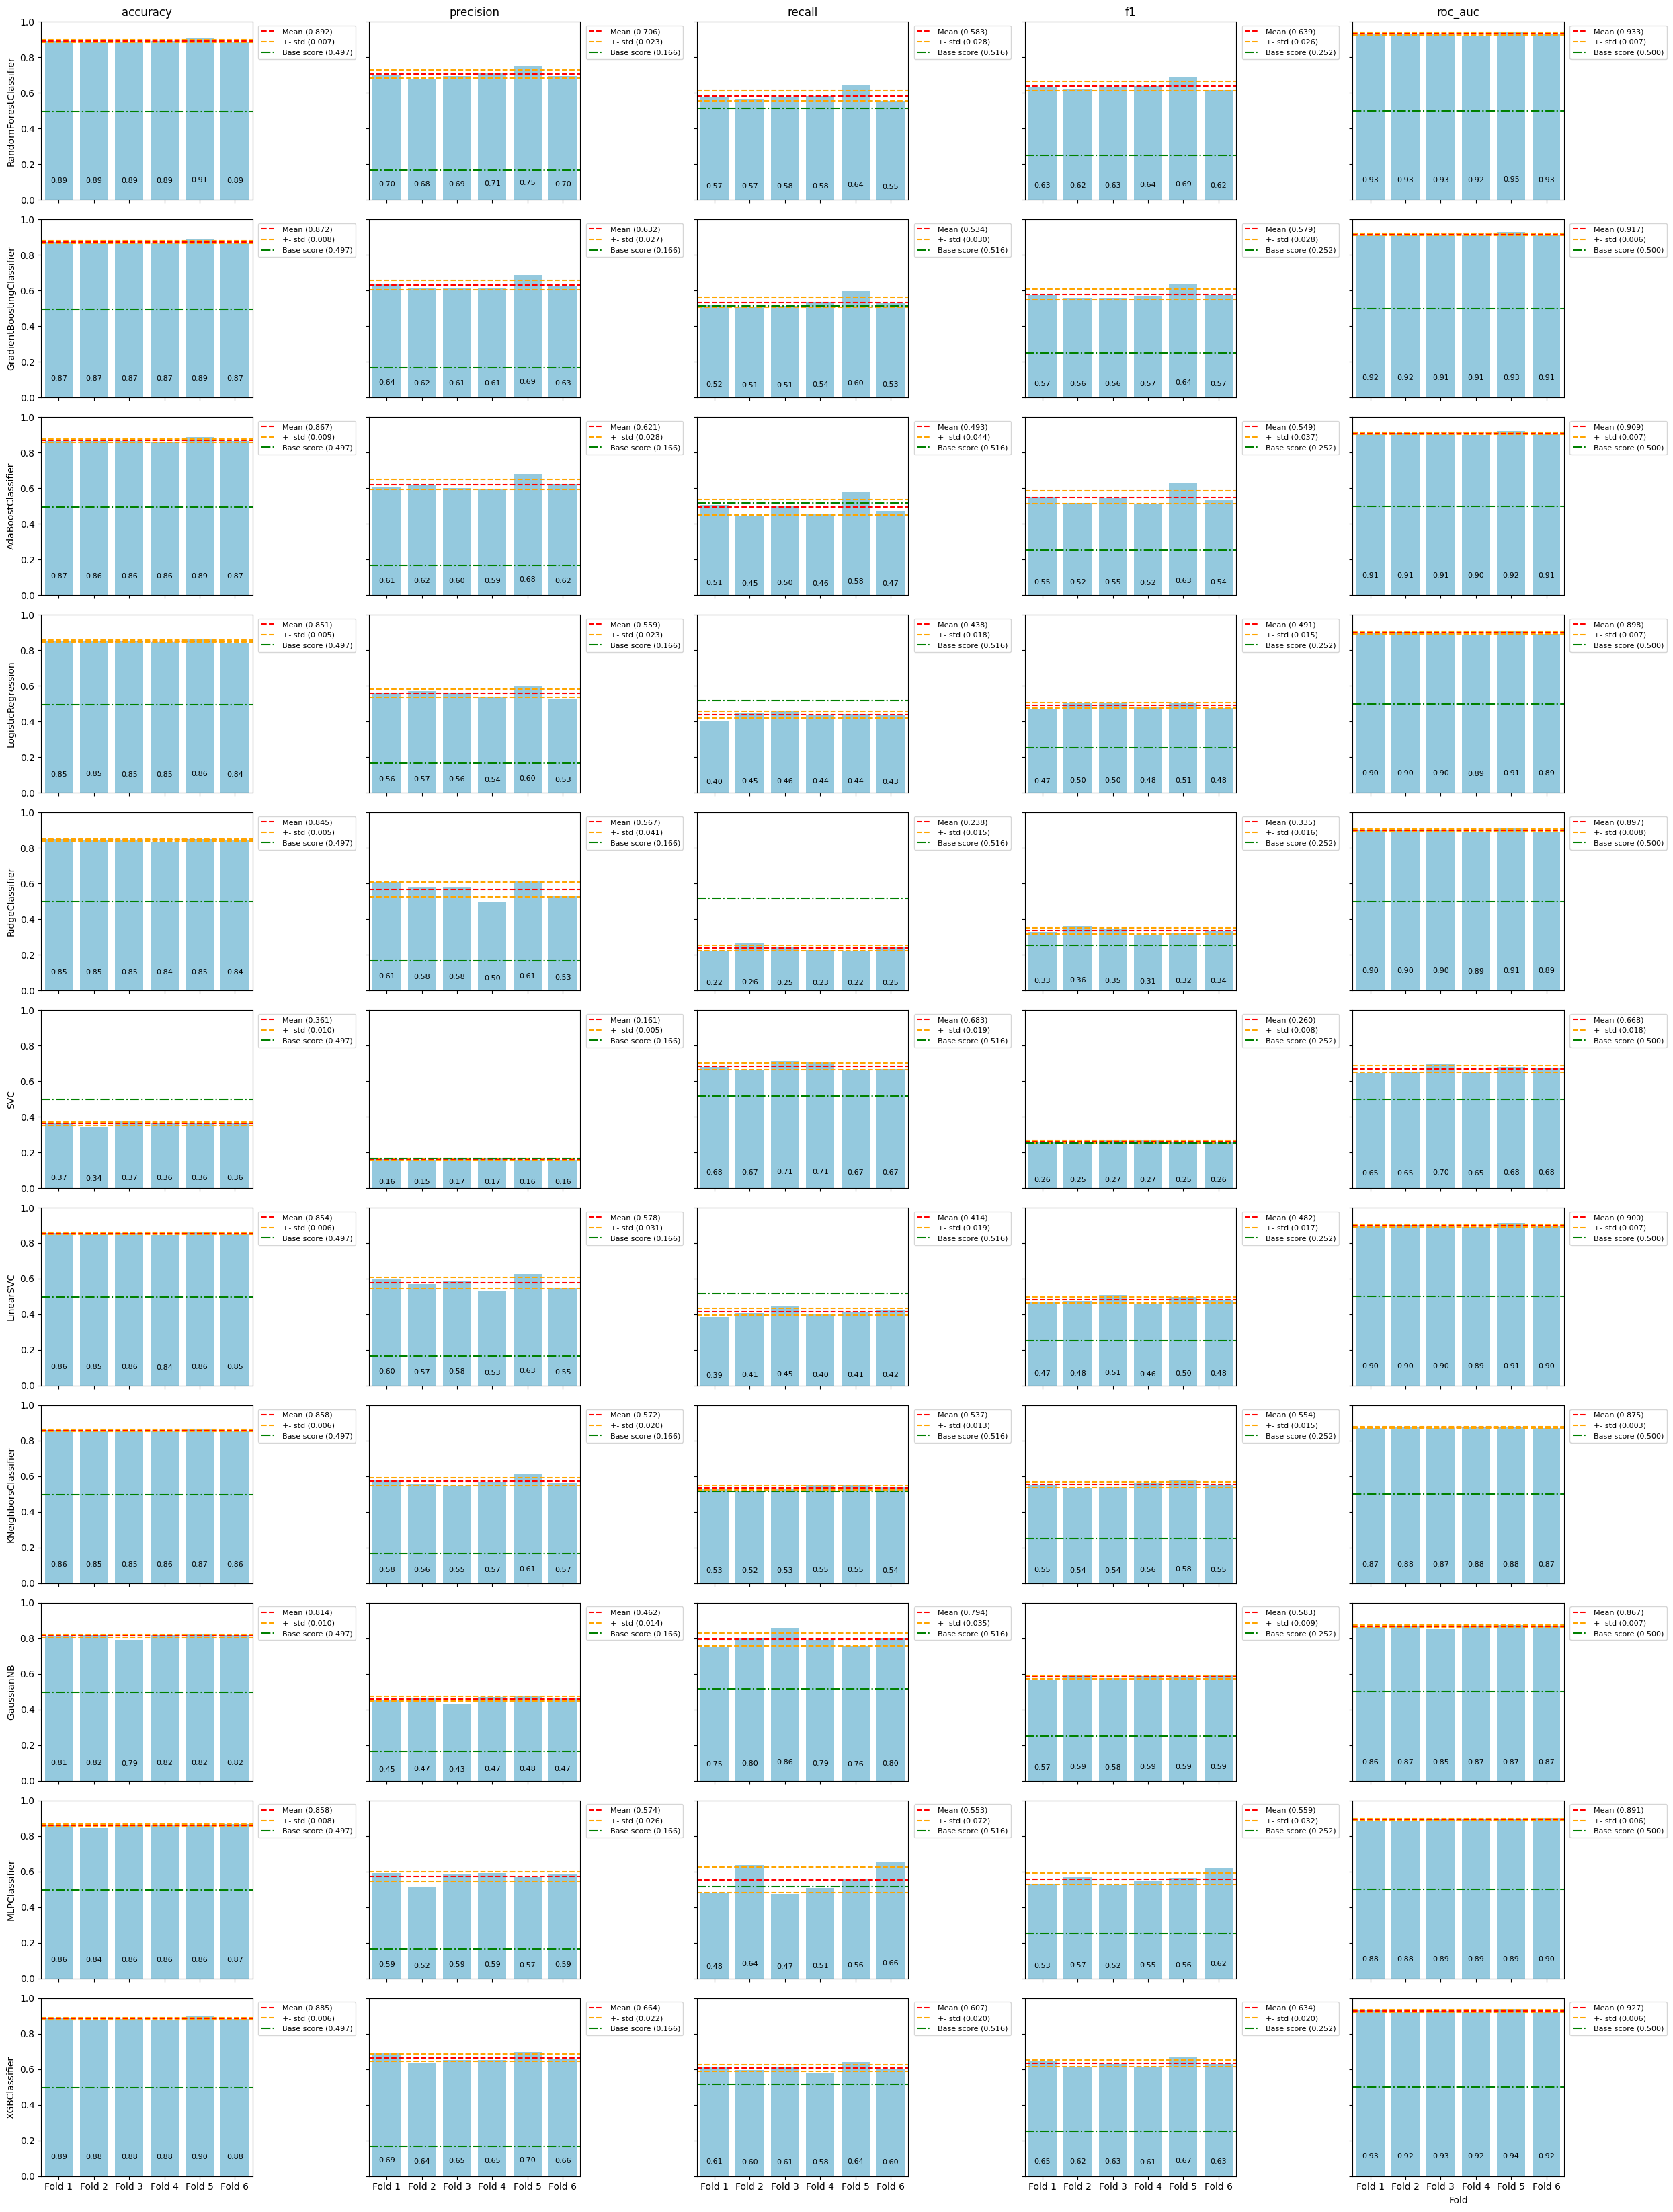

In [3]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

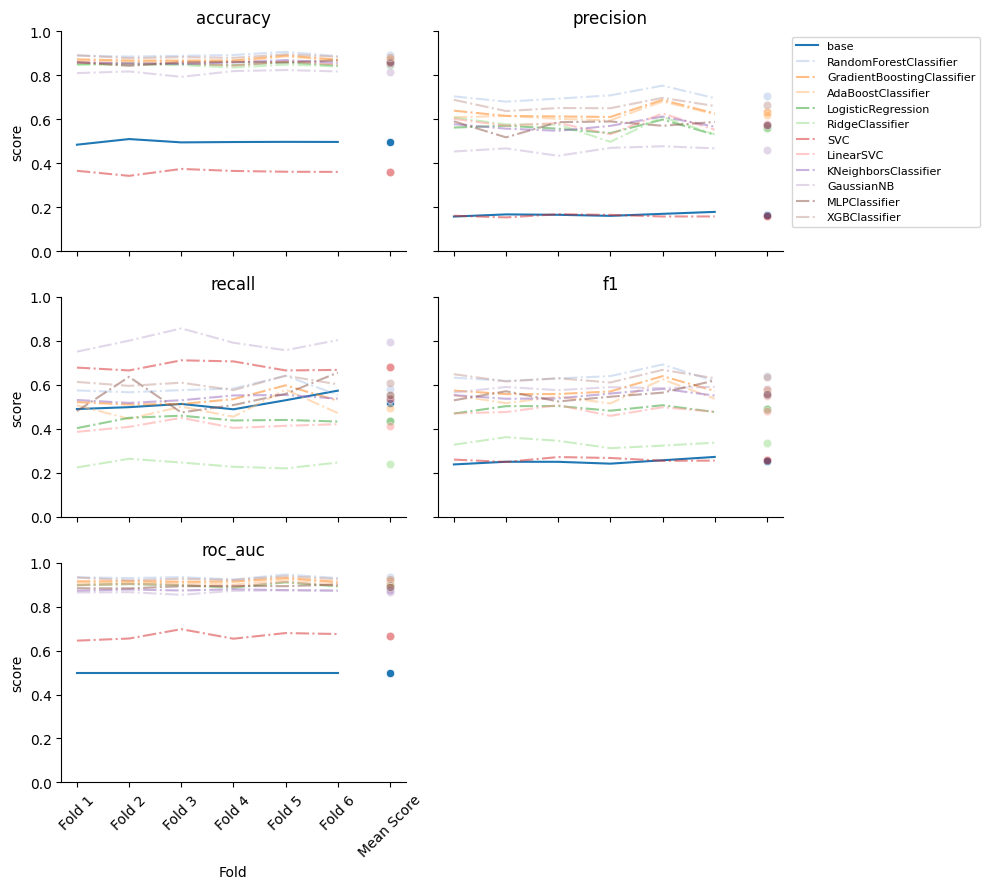

In [4]:
plot_scoring(scoring, scores)

In [5]:
print_scores(scores, "recall")

Models recall
	GaussianNB                    0.7938857111664775
	SVC                           0.6829383599833121
	XGBClassifier                 0.6066934921024825
	RandomForestClassifier        0.5828995644765725
	MLPClassifier                 0.5526712363484655
	KNeighborsClassifier          0.5373158188191348
	GradientBoostingClassifier    0.5344948591079762
	AdaBoostClassifier            0.49333848007392583
	LogisticRegression            0.437690322178163
	LinearSVC                     0.41429117294997914
	RidgeClassifier               0.23840813652899137


In [6]:
print_scores(scores, "f1")

Models f1
	RandomForestClassifier        0.6385009301323504
	XGBClassifier                 0.6340540027889251
	GaussianNB                    0.5831107786032614
	GradientBoostingClassifier    0.5790747046378331
	MLPClassifier                 0.5594895762387225
	KNeighborsClassifier          0.5539355850935707
	AdaBoostClassifier            0.5492881373776033
	LogisticRegression            0.49069298061651995
	LinearSVC                     0.48191654627497477
	RidgeClassifier               0.3348761905954387
	SVC                           0.25996034517417105


In [7]:
print_scores(scores, "roc_auc")

Models roc_auc
	RandomForestClassifier        0.9328199619225073
	XGBClassifier                 0.9271466976381806
	GradientBoostingClassifier    0.9166979077024416
	AdaBoostClassifier            0.9088979595380599
	LinearSVC                     0.8995210164868662
	LogisticRegression            0.8981257017506247
	RidgeClassifier               0.89739705341036
	MLPClassifier                 0.8910742026090981
	KNeighborsClassifier          0.8749405763990152
	GaussianNB                    0.8670563180878653
	SVC                           0.6676875872468301


Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

Therefore further we'll proceed with GaussianNB (highest recall) and XGB Classifier (it can be greatly fine-tuned) and SVC (second highest recall).

In [8]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, XGBClassifier, create_objective, 1)

[I 2024-05-06 17:56:03,803] A new study created in memory with name: no-name-994c5efc-cf22-4599-a993-a66a973736fe
[I 2024-05-06 17:56:05,268] Trial 0 finished with value: 0.885275682268371 and parameters: {'booster': 'gbtree', 'lambda': 0.6206995067490474, 'alpha': 0.0010050933864360224, 'max_depth': 49, 'eta': 0.04187090339806996, 'gamma': 0.015457293635196255, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.885275682268371.


In [9]:
xgb_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, XGBClassifier)

Number of finished trials: 1
Best trial:
  Value: 0.885275682268371
  Params: 
    booster: gbtree
    lambda: 0.6206995067490474
    alpha: 0.0010050933864360224
    max_depth: 49
    eta: 0.04187090339806996
    gamma: 0.015457293635196255
    grow_policy: lossguide
Refitted best model f1-score on valid: 0.8850077279752705


In [10]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            "var_smoothing": trial.suggest_loguniform('var_smoothing', 1e-10, 10.0)
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, GaussianNB, create_objective, 1)

[I 2024-05-06 17:56:07,853] A new study created in memory with name: no-name-ef778759-7f5a-4a2a-889e-e3291744af06
[I 2024-05-06 17:56:08,011] Trial 0 finished with value: 0.8306947609949351 and parameters: {'var_smoothing': 0.015572413308891432}. Best is trial 0 with value: 0.8306947609949351.


In [11]:
gaussian_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, GaussianNB)

Number of finished trials: 1
Best trial:
  Value: 0.8306947609949351
  Params: 
    var_smoothing: 0.015572413308891432
Refitted best model f1-score on valid: 0.8346213292117465


In [12]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        max_iter = trial.suggest_categorical("max_iter", [100])
        probability = trial.suggest_categorical("probability", [True])
        
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 2, 5)
        else:
            degree = 3 
        
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma = trial.suggest_loguniform('gamma', 1e-5, 1e5)
        else:
            gamma = 'scale'
        
        params = {
            "C": C,
            "kernel": kernel,
            "degree": degree,
            "gamma": gamma,
            "max_iter": max_iter,
            "probability": probability
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, SVC, create_objective, 1)

[I 2024-05-06 17:56:08,031] A new study created in memory with name: no-name-97d49a9c-57c9-4cb5-97f4-70a50be643b1
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminat

In [13]:
svc_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, SVC)

Number of finished trials: 1
Best trial:
  Value: 0.192293575566665
  Params: 
    C: 5547.354205452051
    kernel: rbf
    max_iter: 100
    probability: True
    gamma: 88.25233881441238
Refitted best model f1-score on valid: 0.155177743431221


Lets try voting classifier

In [14]:
ensemble_clf = VotingClassifier(estimators=[('XGBClassifier', xgb_classifier), ('GaussianNB', gaussian_classifier), ('SVC', svc_classifier)], voting='soft')

ensemble_clf.fit(X_train, y_train)
y_pred = ensemble_clf.predict(X_val)
score = f1_score(y_val, y_pred, average="micro")

print(f"Refitted best model f1-score on valid: {score}")

Refitted best model f1-score on valid: 0.8574961360123647


## Deep Learning

In [15]:
def get_simple_model(dropout=0.2):
    return tf.keras.Sequential(
        [
            layers.Dense(256, input_shape=(X_train.shape[1],)),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(64),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(1, activation="softmax"),
        ]
    )

In [16]:
simple_classifier_02 = get_simple_model()
simple_classifier_02.summary()
history = train_model(simple_classifier_02, X_train, y_train, X_val, y_val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2808 - loss: 0.3422 - val_f1_score: 0.2682 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2898 - loss: 0.2818 - val_f1_score: 0.2682 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - f1_score: 0.2819 - loss: 0.2727 - val_f1_score: 0.2682 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - f1_score: 0.2835 - loss: 0.2733 - val_f1_score: 0.2682 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2869 - loss: 0.2615 - val_f1_score: 0.2682 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2790 - loss: 0.2654 - val_f1_score: 0.2682 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2871 - loss

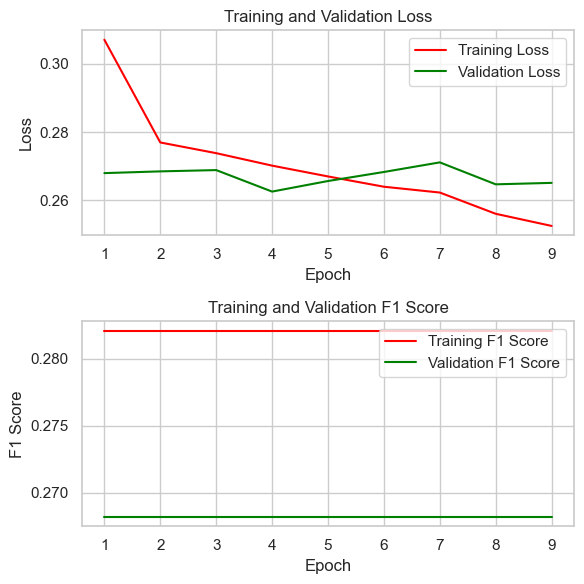

In [17]:
plot_history(history)

In [18]:
simple_classifier_00 = get_simple_model()
simple_classifier_00.summary()
history = train_model(simple_classifier_00, X_train, y_train, X_val, y_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2763 - loss: 0.3508 - val_f1_score: 0.2682 - val_loss: 0.2674 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2775 - loss: 0.2780 - val_f1_score: 0.2682 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2872 - loss: 0.2751 - val_f1_score: 0.2682 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - f1_score: 0.2838 - loss: 0.2679 - val_f1_score: 0.2682 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2767 - loss: 0.2682 - val_f1_score: 0.2682 - val_loss: 0.2784 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2754 - loss: 0.2624 - val_f1_score: 0.2682 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - f1_score: 0.2814 - loss

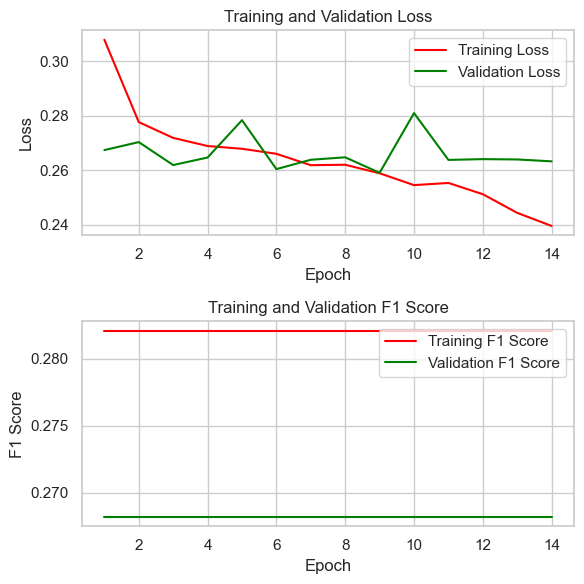

In [19]:
plot_history(history)

In [20]:
def dense_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [21]:
dense_net_classifier = get_simple_model()
dense_net_classifier.summary()
history = train_model(dense_net_classifier, X_train, y_train, X_val, y_val)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2748 - loss: 0.3575 - val_f1_score: 0.2682 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2804 - loss: 0.2779 - val_f1_score: 0.2682 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2756 - loss: 0.2656 - val_f1_score: 0.2682 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - f1_score: 0.2895 - loss: 0.2723 - val_f1_score: 0.2682 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - f1_score: 0.2862 - loss: 0.2623 - val_f1_score: 0.2682 - val_loss: 0.2662 - learning_rate: 5.0000e-04
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - f1_score: 0.2856 - loss: 0.2607 - val_f1_score: 0.2682 - val_loss: 0.2617 - learning_rate: 5.0000e-04
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2

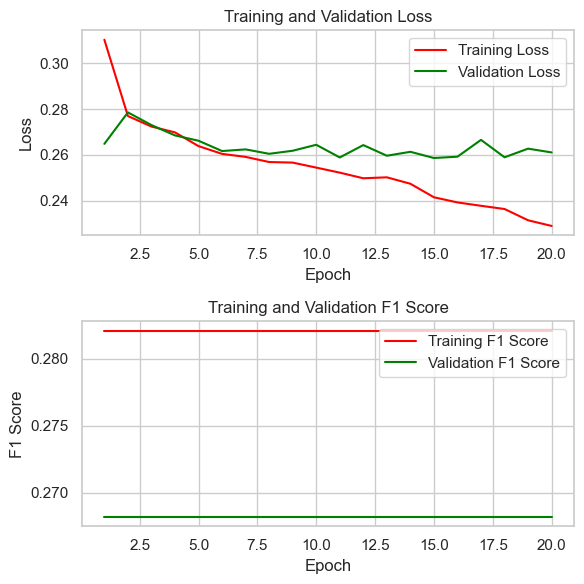

In [22]:
plot_history(history)

In [23]:
def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    residual = x
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Add()([x, residual])
    outputs = layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [24]:
residual_net_classifier = get_simple_model()
residual_net_classifier.summary()
history = train_model(residual_net_classifier, X_train, y_train, X_val, y_val)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2787 - loss: 0.3582 - val_f1_score: 0.2682 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2814 - loss: 0.2793 - val_f1_score: 0.2682 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2894 - loss: 0.2727 - val_f1_score: 0.2682 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.2795 - loss: 0.2648 - val_f1_score: 0.2682 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2861 - loss: 0.2685 - val_f1_score: 0.2682 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - f1_score: 0.2779 - loss: 0.2617 - val_f1_score: 0.2682 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - f1_score: 0.2758 - loss

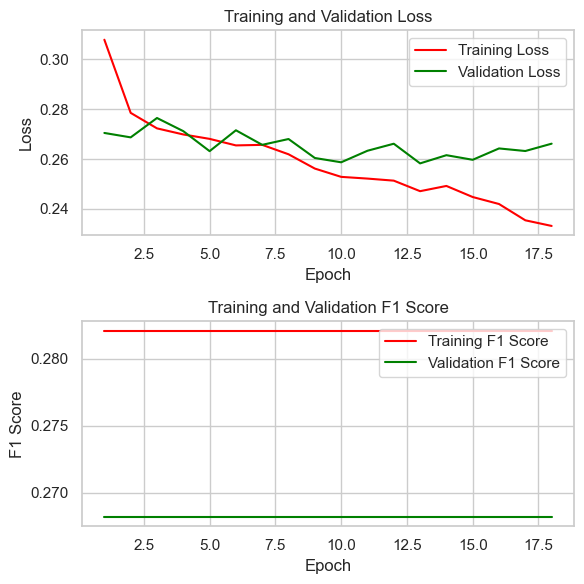

In [25]:
plot_history(history)

In [26]:
class DropConnect(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

def drop_connect_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation='relu')(inputs)
    x = DropConnect(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = DropConnect(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = DropConnect(0.2)(x)
    outputs = layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [27]:
drop_connect_classifier = get_simple_model()
drop_connect_classifier.summary()
history = train_model(drop_connect_classifier, X_train, y_train, X_val, y_val)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2856 - loss: 0.3437 - val_f1_score: 0.2682 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2779 - loss: 0.2729 - val_f1_score: 0.2682 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2831 - loss: 0.2716 - val_f1_score: 0.2682 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2829 - loss: 0.2637 - val_f1_score: 0.2682 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2833 - loss: 0.2661 - val_f1_score: 0.2682 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2805 - loss: 0.2633 - val_f1_score: 0.2682 - val_loss: 0.2665 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2861 - loss: 0.

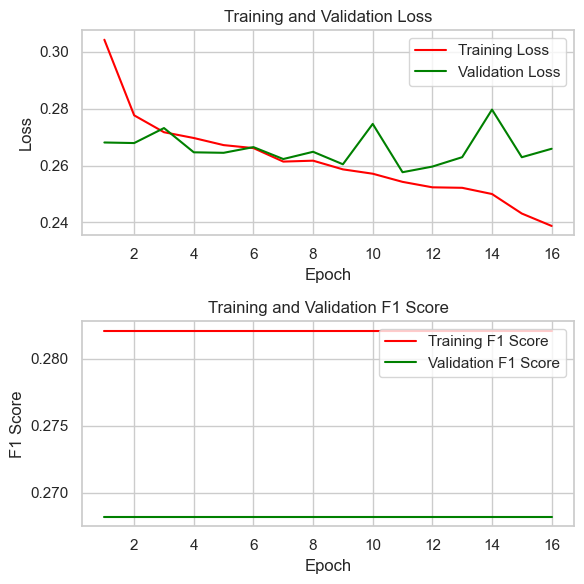

In [28]:
plot_history(history)

# Final model

Based on above research we'll go into production with our voting classifier. We believe it'll have best generalization capabilities and it will focus more on recall to precision.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = pipeline
        self.model = ensemble_clf
    
    def predict(self, X):
        if "FINALIZED_LOAN" not in X.columns:
            X["FINALIZED_LOAN"] = np.ones(X.shape[0])
        
        X = pipeline.transform(X)
        X.drop(columns=["FINALIZED_LOAN"], inplace=True)
        return ensemble_clf.predict(X.values)    

    def set_output(self, *args, **kwargs):
        return self


In [71]:
df_val = pd.read_csv("../data/orig_valid.csv")
y_val = df_val["FINALIZED_LOAN"]
df_val.drop(columns=["FINALIZED_LOAN"], inplace=True)

final_model = FinalModel()
y_pred = final_model.predict(df_val)

In [78]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2734
           1       0.62      0.18      0.28       501

    accuracy                           0.86      3235
   macro avg       0.74      0.58      0.60      3235
weighted avg       0.83      0.86      0.82      3235



In [64]:
joblib.dump(
    final_model, "../pipelines/final_model.joblib"
)

['../pipelines/final_model.joblib']